# Classification Pipeline

In [ ]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path
import scipy.stats as st

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import LinearSVC, SVC
from src.sugnet.pipeline import extract_features

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE


In [ ]:
CV = GroupShuffleSplit(n_splits=10, test_size=0.2)
CHANCE_CV = GroupShuffleSplit(n_splits=100, test_size=0.2)
n_permutations = 100
output_path = Path('data/classification_output')

In [ ]:
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)

# clean unwanted observations
DATA = DATA.query('description == "hypnosis"')
DATA = DATA.query('condition.str.contains("experience")')


DATA = DATA.query('bids_id <= 50')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

#Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [ ]:
# 2. PIPELINE
pipe = Pipeline([
    ('extract', FunctionTransformer(extract_features,
                                    kw_args={'kind': 'correlation source',
                                             'frequency_band': 'beta'},
                                   #TODO validate=True
                                    )),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('pca', PCA(n_components=30)),
    # ('select', SelectFromModel(LinearSVC(penalty='l2', max_iter=100000, dual=False,))),
    # ('clf', LinearSVC(penalty='l2', max_iter=100000, dual=False)),
    ('select', SelectFromModel(SVC(kernel="linear", max_iter=100000), max_features=13)),
    ('clf', SVC(kernel="linear", max_iter=100000, probability=True)),
])
# DEBUG: pipe.fit(X, y).score(X, y)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe, X, y, groups=groups, cv=CV, scoring='accuracy')
scores.mean(), scores.std(), st.bootstrap(scores.reshape(1, -1), np.mean)


In [ ]:
grid_params = {
    'extract__kw_args': [
        dict(kind='correlation source', frequency_band='alpha'),
        dict(kind='correlation source', frequency_band='theta'),
        dict(kind='correlation source', frequency_band='beta'),
        dict(kind='correlation source', frequency_band='gamma'),
        
        dict(kind='power sensor', frequency_band='alpha'),
        dict(kind='power sensor', frequency_band='theta'),
        dict(kind='power sensor', frequency_band='beta'),
        dict(kind='power sensor', frequency_band='gamma'),
        
        dict(kind='power source', frequency_band='alpha'),
        dict(kind='power source', frequency_band='theta'),
        dict(kind='power source', frequency_band='beta'),
        dict(kind='power source', frequency_band='gamma'),
        
        dict(kind='plv source', frequency_band='alpha'),
        dict(kind='plv source', frequency_band='theta'),
        dict(kind='plv source', frequency_band='beta'),
        dict(kind='plv source', frequency_band='gamma'),
        
        dict(kind='correlation sensor'),
    ]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1)
grid.fit(X, y, groups=groups)


In [ ]:
# prepare grid results to plot
grid_results = pd.DataFrame(grid.cv_results_)
grid_results['label'] = grid_results['params'].apply(lambda p: ' '.join(list(p.values())[0].values()))

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')


def fit_chance(model_name=None):
    """Utility function to simulate emperical chance level."""
    
    chance_model = DummyClassifier(strategy='most_frequent')
    chance_scores = cross_val_score(chance_model, X, y, groups=groups, cv=CHANCE_CV, scoring='accuracy')
    return chance_scores

chance_scores = {}
for model_name in grid_results['label'].unique():
    model_chance_scores = fit_chance(model_name)
    chance_scores[f'{model_name}'] = model_chance_scores.tolist()
    
chance_scores = pd.DataFrame(chance_scores).melt(var_name='label', value_name='test_score')

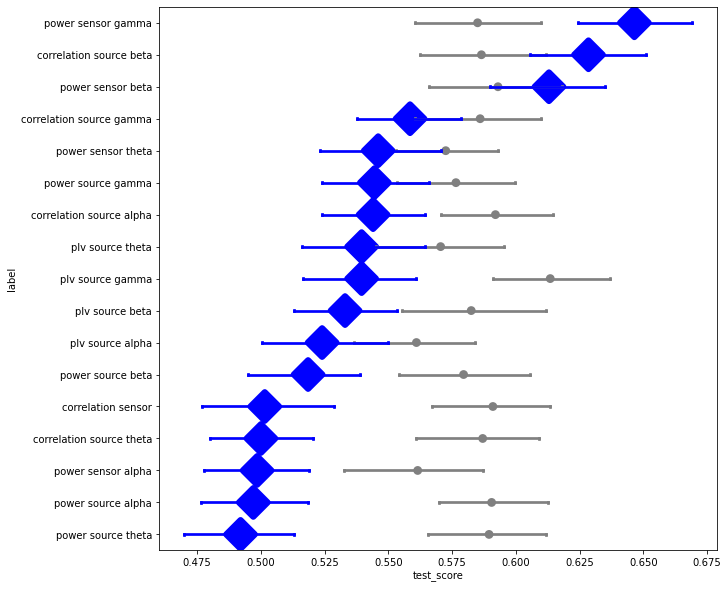

In [142]:
# plot model performance against chance level
import seaborn as sns

import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(10, 10))
order = grid_results.groupby('label')['test_score'].mean().sort_values(ascending=False).index.values

# plot chance
sns.pointplot(data=chance_scores, ax=ax,
              x='test_score', y='label',
              order=order,
              color='gray',
              capsize=0.03,
              join=False,
              orient='h', label='chance')

# plot observed
sns.pointplot(data=grid_results, x='test_score', y='label',
              orient='h',
              order=order,
              ax=ax,
              scale=3,
              cmap='viridis',
              capsize=0.03,
              join=False,
              color='blue',
              markers='D')

# sns.stripplot(data=grid_results, x='test_score', y='label',
#               orient='h',
#               order=order,
#               ax=ax,
#               cmap='viridis',
#               color='blue',
#               marker='D')

plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

pipe.set_params(**grid.best_params_)
X_t = pipe[:-2].fit_transform(X, y)

permutation_importance(pipe[-2:], X_t, y, n_repeats=10)